1D inverse probem demo using deriv2 from regtools

We roughly translated deriv2 (P. C. Hansen, Regularization Tools Version 4.0 for Matlab 7.3, Numerical Algorithms, 46 (2007), pp. 189-194.) to Python. The righthand side vector b is made as Ax so is "exact" as a vector. We will look at the SDV and regularized solution as an example of a mildly ill posed problem and show how to recostruct using the Core Imaging Library (CIL. See Jørgensen, Jakob S., et al. "Core Imaging Library-Part I: a versatile Python framework for tomographic imaging." Philosophical Transactions of the Royal Society A 379.2204 (2021): 20200192. and https://tomographicimaging.github.io/CIL/nightly/index.html). 

This notebook was developed as part of the CCPi CIL Hackathon https://ccpi.ac.uk/events/byod-cil-hackathon/ in March 2023 in Cambridge as part of the Rich Nonlinear Tomography programme at the Isaac Newton Institute for Mathematical Sciences https://www.newton.ac.uk/event/rnt/.  The CIL is suppored by the CCPi EPSRC grant EP/T026677/1 and the Isaac NewtonInstitute by EP/R014604/1 The author would like to thank the Isaac Newton Institute for support  and hospitality.(c) W.R.B. Lionheart 2023. Apache License

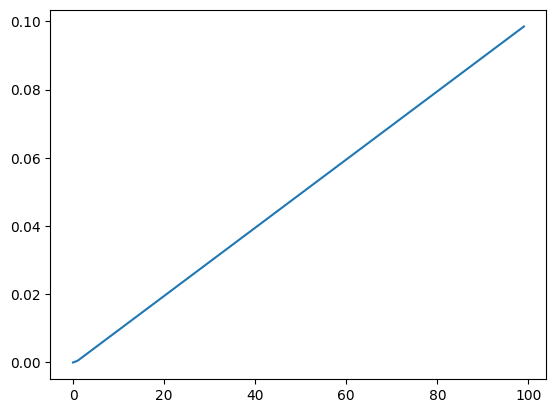

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import MatrixOperator
from cil.framework import VectorData, BlockDataContainer
from deriv2 import deriv2
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator


# Test of one dimensional inverse problems using deriv2 from reg tools
n = 100
m = n
A,b,x = deriv2(n,1)

plt.plot(x)


This has made a A,X, and b where Ax=b. The rhs b s exact to floating point error

In [2]:
np.linalg.norm(A@x-b)

0.0

Now make a version of b with noise

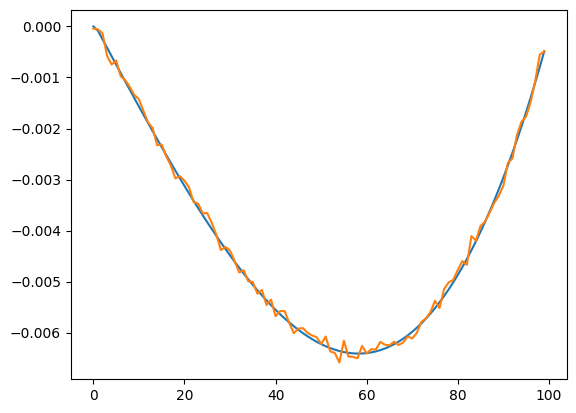

In [61]:
bn= b + 0.0001*np.random.randn(n)
plt.plot(b)
plt.plot(bn)

A x and b are Numpy arrays. Just as in Matlab we can look at the singular value decomposition.   On a log scale we see the singular values dacay as a negative power as expect for an operator that approximates the inverse of two derivatives.


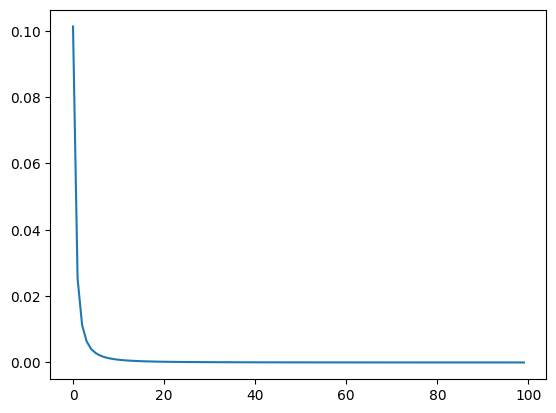

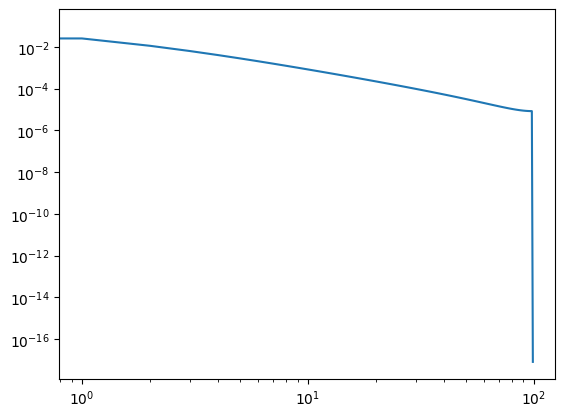

In [3]:
u, s, vh = np.linalg.svd(A, full_matrices=True)
plt.plot(s)
plt.figure()
plt.loglog(s)

Now solve using Tikonov regularization. A small regularization parameter is Ok as only mildly ill conditioned 
and no noise was added to b. 

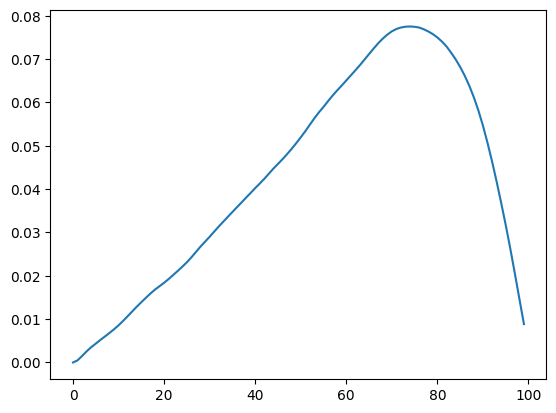

In [75]:
Atik=np.vstack((A,0.01*np.eye(n))) 

btik = np.hstack((bn,np.zeros(n)))

xtik =  np.linalg.lstsq(Atik,btik,rcond=None)[0]
plt.plot(xtik)

Now convert the matrix and operators to CIL types

In [76]:
Aop = MatrixOperator(A)
bop= VectorData(bn) 


In [93]:
#bop = VectorData(np.reshape(b,[-1]))
op = VectorData(bn)
cgls = CGLS(operator=Aop, data=bop, max_iteration=4, update_objctive_interval=10)
cgls.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0          4         0.000          2.09949e-03
        1          4         0.190          3.28010e-05
        2          4         0.199          3.27442e-06
        3          4         0.184          1.38428e-06
        4          4         0.176          1.08585e-06
-------------------------------------------------------
        4          4         0.176          1.08585e-06
Stop criterion has been reached.



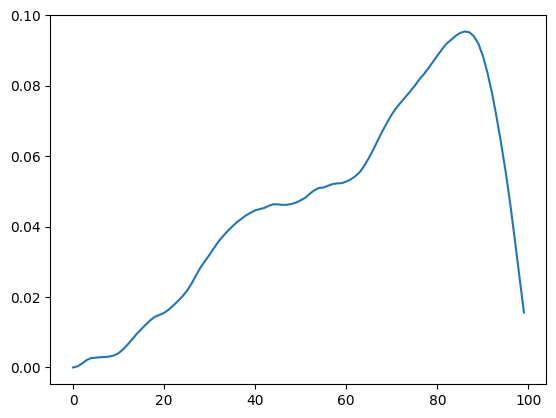

In [94]:
plt.plot(cgls.solution.as_array())

Now have a look at the SVD

In [95]:
xlq=np.linalg.lstsq(A,bn,rcond=None)[0]

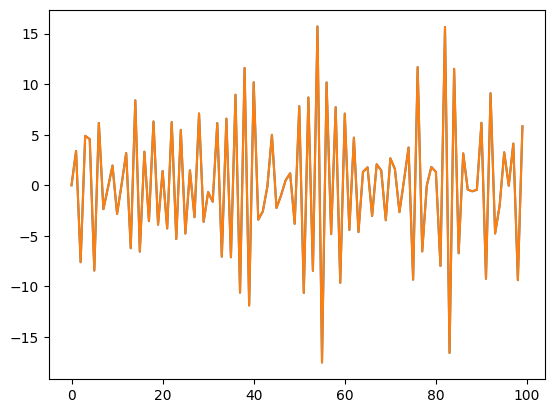

In [97]:
plt.plot(xlq);plt.plot(xlq)

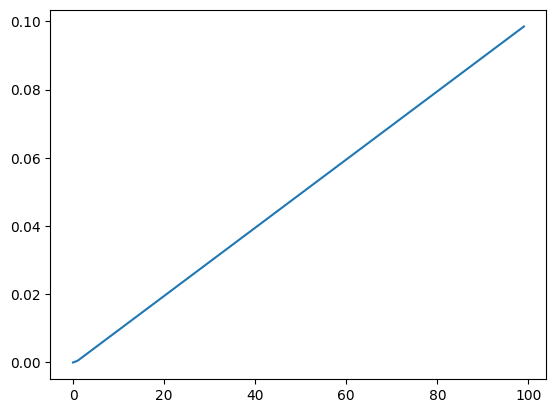

In [66]:
plt.plot(x)

In [122]:
ig = Aop.domain_geometry()
L = IdentityOperator(ig)
# L=np.identity(n)
alpha = 0.01

operator_block = BlockOperator(Aop, alpha*L)

In [123]:
zero_data = L.range.allocate(0)

data_block = BlockDataContainer(bop, zero_data)

In [124]:
cglsb = CGLS(operator=operator_block, data=data_block, max_iteration=1000, update_objctive_interval=10)
cglsb.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          2.09949e-03
        1       1000         0.194          5.27601e-05
        2       1000         0.178          2.77588e-05
        3       1000         0.178          2.70079e-05
        4       1000         0.183          2.69912e-05
        5       1000         0.175          2.69910e-05
        6       1000         0.179          2.69910e-05
Tolerance is reached: 1e-06
-------------------------------------------------------
        6       1000         0.179          2.69910e-05
Stop criterion has been reached.



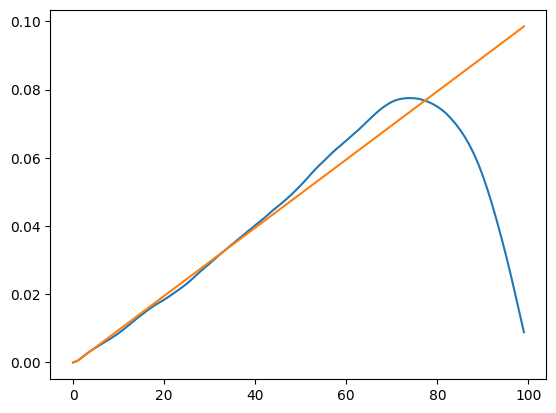

In [126]:
plt.plot(cglsb.solution.as_array())
plt.plot(x)